### Implementing FunkSVD

In this notebook we will take a look at writing our own function that performs FunkSVD, which will follow the steps you saw in the previous video.  If you find that you aren't ready to tackle this task on your own, feel free to skip to the following video where you can watch as I walk through the steps.

To test our algorithm, we will run it on the subset of the data you worked with earlier.  Run the cell below to get started.

In [42]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
import svd_tests as t
%matplotlib inline

# Read in the datasets
movies = pd.read_csv('data/movies_clean.csv')
reviews = pd.read_csv('data/reviews_clean.csv')

del movies['Unnamed: 0']
del reviews['Unnamed: 0']

# Create user-by-item matrix
user_items = reviews[['user_id', 'movie_id', 'rating', 'timestamp']]
user_by_movie = user_items.groupby(['user_id', 'movie_id'])['rating'].max().unstack()

# Create data subset
user_movie_subset = user_by_movie[[73486, 75314,  68646, 99685]].dropna(axis=0)
ratings_mat = np.matrix(user_movie_subset)
print(ratings_mat)

[[10. 10. 10. 10.]
 [10.  4.  9. 10.]
 [ 8.  9. 10.  5.]
 [ 9.  8. 10. 10.]
 [10.  5.  9.  9.]
 [ 6.  4. 10.  6.]
 [ 9.  8. 10.  9.]
 [10.  5.  9.  8.]
 [ 7.  8. 10.  8.]
 [ 9.  5.  9.  7.]
 [ 9.  8. 10.  8.]
 [ 9. 10. 10.  9.]
 [10.  9. 10.  8.]
 [ 5.  8.  5.  8.]
 [10.  8. 10. 10.]
 [ 9.  9. 10. 10.]
 [ 9.  8.  8.  8.]
 [10.  8.  1. 10.]
 [ 5.  6. 10. 10.]
 [ 8.  7. 10.  7.]]


In [43]:
import math
math.isnan(ratings_mat[0,0])

False

In [44]:
ratings_mat.shape

(20, 4)

`1.` You will use the **user_movie_subset** matrix to show that your FunkSVD algorithm will converge.  In the below cell, use the comments and document string to assist you as you complete writing your own function to complete FunkSVD.  You may also want to try to complete the function on your own without the assistance of comments.  You may feel free to remove and add to the function in any way that gets you a working solution! 

**Notice:** There isn't a sigma matrix in this version of the matrix factorization.

In [45]:
np.random.seed(1)
user_mat = np.random.rand(20, 4)
print(user_mat)
print(user_mat[0,:])
print(user_mat[:,0])

[[4.17022005e-01 7.20324493e-01 1.14374817e-04 3.02332573e-01]
 [1.46755891e-01 9.23385948e-02 1.86260211e-01 3.45560727e-01]
 [3.96767474e-01 5.38816734e-01 4.19194514e-01 6.85219500e-01]
 [2.04452250e-01 8.78117436e-01 2.73875932e-02 6.70467510e-01]
 [4.17304802e-01 5.58689828e-01 1.40386939e-01 1.98101489e-01]
 [8.00744569e-01 9.68261576e-01 3.13424178e-01 6.92322616e-01]
 [8.76389152e-01 8.94606664e-01 8.50442114e-02 3.90547832e-02]
 [1.69830420e-01 8.78142503e-01 9.83468338e-02 4.21107625e-01]
 [9.57889530e-01 5.33165285e-01 6.91877114e-01 3.15515631e-01]
 [6.86500928e-01 8.34625672e-01 1.82882773e-02 7.50144315e-01]
 [9.88861089e-01 7.48165654e-01 2.80443992e-01 7.89279328e-01]
 [1.03226007e-01 4.47893526e-01 9.08595503e-01 2.93614148e-01]
 [2.87775339e-01 1.30028572e-01 1.93669579e-02 6.78835533e-01]
 [2.11628116e-01 2.65546659e-01 4.91573159e-01 5.33625451e-02]
 [5.74117605e-01 1.46728575e-01 5.89305537e-01 6.99758360e-01]
 [1.02334429e-01 4.14055988e-01 6.94400158e-01 4.141792

In [99]:
def FunkSVD(ratings_mat, latent_features=4, learning_rate=0.0001, iters=100):
    '''
    This function performs matrix factorization using a basic form of FunkSVD with no regularization
    
    INPUT:
    ratings_mat - (numpy array) a matrix with users as rows, movies as columns, and ratings as values
    latent_features - (int) the number of latent features used
    learning_rate - (float) the learning rate 
    iters - (int) the number of iterations
    
    OUTPUT:
    user_mat - (numpy array) a user by latent feature matrix
    movie_mat - (numpy array) a latent feature by movie matrix
    '''
    
    # Set up useful values to be used through the rest of the function
    n_users = ratings_mat.shape[0]
    n_movies = ratings_mat.shape[1]
    num_ratings = n_users * n_movies
    
    # initialize the user and movie matrices with random values
    # helpful link: https://docs.scipy.org/doc/numpy/reference/generated/numpy.random.rand.html
    user_mat = np.random.rand(n_users, latent_features)  # user matrix filled with random values of shape user x latent 
    movie_mat = np.random.rand(latent_features, n_movies) # movie matrix filled with random values of shape latent x movies
    
    # initialize sse at 0 for first iteration
    sse_accum = 0
    
    # header for running results
    print("Optimization Statistics")
    print("Iterations | Mean Squared Error ")
    
    user_movie_index = []
    #movie_index = []
    
    # check what is not NaN
    for user_i in range(n_users):
        for movie_j in range(n_movies):
            if(math.isnan(ratings_mat[user_i,movie_j])==False):
                user_movie_index.append([user_i,movie_j])
                #print(user_i,movie_j)
    
    
    # for each iteration
    sse = []
    for t in range(iters):
        
        # update our sse
        old_sse = sse_accum
        sse_accum = 0
        
        
        for pairs in user_movie_index:
            user_i = pairs[0]
            movie_j = pairs[1]
            
            # row of U
            #u = user_mat[user_i,:]
            # column of Vt
            #v = movie_mat[:,movie_j]
            
            # dot product
            uv_new = np.dot(user_mat[user_i,:], movie_mat[:,movie_j])
            delta = (ratings_mat[user_i, movie_j] - uv_new)
            #print(delta)
            sse_accum += delta**2.0 #sum of the square error
            
            user_mat[user_i,:] = user_mat[user_i,:] + 2.0 * (delta) * learning_rate * movie_mat[:,movie_j]
            movie_mat[:,movie_j] = movie_mat[:,movie_j] + 2.0 * (delta) * learning_rate * user_mat[user_i,:] 
#             for k in range(latent_features):
#                 user_mat[user_i,k] = user_mat[user_i,k] + 2.0 * (delta) * learning_rate * movie_mat[k,movie_j]
                
#             for k in range(latent_features):
#                 movie_mat[k,movie_j] = movie_mat[k,movie_j] + 2.0 * (delta) * learning_rate * user_mat[user_i,k]  
            
            #user_mat[user_i,:] = u
            #movie_mat[:,movie_j] = v
        sse.append(sse_accum)
        if(t%1==0):
            print('iteration {}: sse_accum {}'.format(t+1, sse_accum))
    plt.plot(sse)  
    plt.title('iteration {}: sse_accum {}, learning rate {}'.format(t+1, sse_accum, learning_rate))
    plt.show()
    return user_mat, movie_mat 

`2.` Try out your function on the **user_movie_subset** dataset.  First try 4 latent features, a learning rate of 0.005, and 10 iterations.  When you take the dot product of the resulting U and V matrices, how does the resulting **user_movie** matrix compare to the original subset of the data?

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 3436.5796280201725


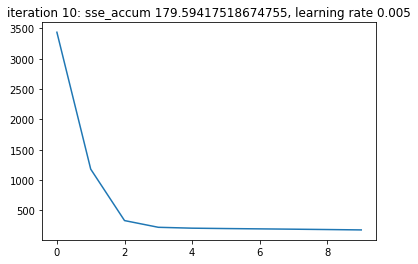

In [91]:
user_mat, movie_mat = FunkSVD(ratings_mat, 4, 0.005, 10) # use your function with 4 latent features, lr of 0.005 and 10 iterations

In [92]:
#Compare the predicted and actual results
print(np.dot(user_mat, movie_mat))
print(ratings_mat)

[[10.08506649  8.87690981 10.56348172 10.17948179]
 [ 8.74466158  7.41788902  9.33504629  8.47923332]
 [ 8.11149269  6.53469087  8.72592034  7.44997682]
 [ 9.48567716  8.54476386  9.64386912  9.78900096]
 [ 8.72975459  7.25186852  9.28628246  8.23631225]
 [ 6.93124188  5.47888307  8.21411981  6.24292112]
 [ 9.36727143  7.77691379 10.10803059  8.86220174]
 [ 8.1713472   6.95440423  8.90719632  8.07290016]
 [ 8.41951844  7.56766937  8.79853068  8.52893329]
 [ 7.74474435  6.5049275   8.52575128  7.33570799]
 [ 8.88228577  7.90677032  9.13253229  8.93083516]
 [ 9.64592732  8.67140957  9.5459683   9.82414744]
 [ 9.47992797  8.00682512  9.90908959  9.01084877]
 [ 6.49298606  6.08367305  6.42822661  6.98834117]
 [ 9.75505153  8.58877665 10.09543689  9.80289289]
 [ 9.78637924  8.58006746 10.02442093  9.84694623]
 [ 8.43716149  7.25866001  8.58598959  8.28024282]
 [ 6.91922047  6.74529924  6.34925154  7.78959747]
 [ 8.16412345  7.25331633  8.85987661  8.48334566]
 [ 7.99162715  7.07221941  8.54

**Write your summary here.**

`3.` Let's try out the function again on the **user_movie_subset** dataset.  This time we will again use 4 latent features and a learning rate of 0.005.  However, let's bump up the number of iterations to 250.  When you take the dot product of the resulting U and V matrices, how does the resulting **user_movie** matrix compare to the original subset of the data?  What do you notice about your error at the end of the 250 iterations?

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 3843.967752076332
iteration 11: sse_accum 213.61766863668277
iteration 21: sse_accum 188.92791725304076
iteration 31: sse_accum 126.9614484979148
iteration 41: sse_accum 50.86968547645895
iteration 51: sse_accum 8.13542620424383
iteration 61: sse_accum 0.9917028936262015
iteration 71: sse_accum 0.16636807484387964
iteration 81: sse_accum 0.03502153688638914
iteration 91: sse_accum 0.008334266409753583
iteration 101: sse_accum 0.0021334305063987376
iteration 111: sse_accum 0.0005718069254050863
iteration 121: sse_accum 0.00015785325158062928
iteration 131: sse_accum 4.441459776673403e-05
iteration 141: sse_accum 1.2649638415933583e-05
iteration 151: sse_accum 3.6303588109892543e-06
iteration 161: sse_accum 1.0468012925627798e-06
iteration 171: sse_accum 3.026947143528094e-07
iteration 181: sse_accum 8.767128738829523e-08
iteration 191: sse_accum 2.5415907428812958e-08
iteration 201: sse_accum 7.3715658837341

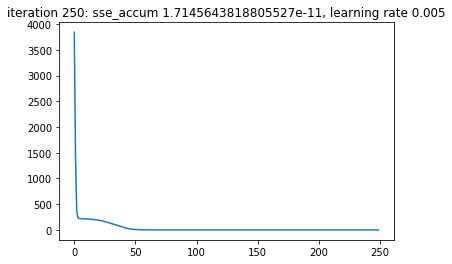

In [93]:
user_mat, movie_mat = FunkSVD(ratings_mat, 4, 0.005, 250) #use your function with 4 latent features, lr of 0.005 and 250 iterations

In [94]:
#Compare the predicted and actual results
print(np.dot(user_mat, movie_mat))
print(ratings_mat)

[[ 9.99999931  9.99999954  9.99999975 10.00000083]
 [ 9.99999979  3.99999988  8.99999994 10.00000024]
 [ 8.00000026  9.00000019 10.00000011  4.99999969]
 [ 9.00000007  8.00000003 10.00000003  9.99999994]
 [ 9.9999994   4.99999963  8.9999998   9.0000007 ]
 [ 6.00000044  4.00000029 10.00000017  5.99999948]
 [ 8.9999999   7.99999995  9.99999998  9.00000012]
 [10.00000059  5.0000004   9.00000023  7.9999993 ]
 [ 6.99999944  7.99999964  9.9999998   8.00000067]
 [ 9.00000048  5.00000028  9.00000017  6.99999946]
 [ 9.00000061  8.00000039 10.00000022  7.99999929]
 [ 9.00000022 10.00000013 10.00000007  8.99999975]
 [ 9.99999964  8.99999975  9.99999985  8.00000043]
 [ 5.00000034  8.00000023  5.00000013  7.99999959]
 [ 9.999999    7.99999932  9.99999962 10.00000121]
 [ 8.99999979  8.9999999   9.99999995 10.00000023]
 [ 9.00000038  8.00000028  8.00000016  7.99999954]
 [10.0000003   8.0000002   1.00000012  9.99999966]
 [ 5.00000041  6.00000027 10.00000015  9.99999952]
 [ 7.99999987  6.99999992  9.99

**Write your summary here.**

The last time we placed an **np.nan** value into this matrix the entire svd algorithm in python broke.  Let's see if that is still the case using your FunkSVD function.  In the below cell, I have placed a nan into the first cell of your numpy array.  

`4.` Use 4 latent features, a learning rate of 0.005, and 250 iterations.  Are you able to run your SVD without it breaking (something that was not true about the python built in)?  Do you get a prediction for the nan value?  What is your prediction for the missing value? Use the cells below to answer these questions.

In [95]:
# Here we are placing a nan into our original subset matrix
ratings_mat[0, 0] = np.nan
ratings_mat

matrix([[nan, 10., 10., 10.],
        [10.,  4.,  9., 10.],
        [ 8.,  9., 10.,  5.],
        [ 9.,  8., 10., 10.],
        [10.,  5.,  9.,  9.],
        [ 6.,  4., 10.,  6.],
        [ 9.,  8., 10.,  9.],
        [10.,  5.,  9.,  8.],
        [ 7.,  8., 10.,  8.],
        [ 9.,  5.,  9.,  7.],
        [ 9.,  8., 10.,  8.],
        [ 9., 10., 10.,  9.],
        [10.,  9., 10.,  8.],
        [ 5.,  8.,  5.,  8.],
        [10.,  8., 10., 10.],
        [ 9.,  9., 10., 10.],
        [ 9.,  8.,  8.,  8.],
        [10.,  8.,  1., 10.],
        [ 5.,  6., 10., 10.],
        [ 8.,  7., 10.,  7.]])

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 3553.5458482332874
iteration 11: sse_accum 197.5677248016898
iteration 21: sse_accum 125.22260525203991
iteration 31: sse_accum 54.792339019550674
iteration 41: sse_accum 27.502925018874784
iteration 51: sse_accum 10.284901959928373
iteration 61: sse_accum 2.4014187385329393
iteration 71: sse_accum 0.5101868658036383
iteration 81: sse_accum 0.12619526075764925
iteration 91: sse_accum 0.03481866992950576
iteration 101: sse_accum 0.010007686466541875
iteration 111: sse_accum 0.0029141530338930247
iteration 121: sse_accum 0.000852480916186519
iteration 131: sse_accum 0.0002499210968698693
iteration 141: sse_accum 7.3372946500042e-05
iteration 151: sse_accum 2.1564624580741363e-05
iteration 161: sse_accum 6.343543828086432e-06
iteration 171: sse_accum 1.8674000012879914e-06
iteration 181: sse_accum 5.500494267615186e-07
iteration 191: sse_accum 1.6209835913542805e-07
iteration 201: sse_accum 4.778925024378171e-

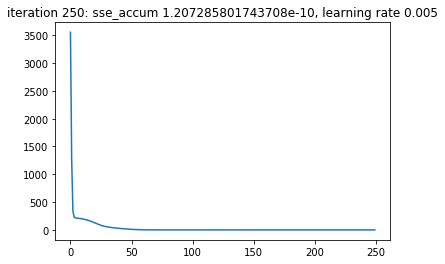

In [96]:
# run SVD on the matrix with the missing value
user_mat, movie_mat = FunkSVD(ratings_mat, 4, 0.005, 250) #use your function with 4 latent features, lr of 0.005 and 250 iterations

In [97]:
# Run this cell to see if you were able to predict for the missing value
preds = np.dot(user_mat, movie_mat)
print("The predicted value for the missing rating is {}:".format(preds[0,0]))
print()
print("The actual value for the missing rating is {}:".format(ratings_mat[0,0]))
print()
assert np.isnan(preds[0,0]) == False
print("That's right! You just predicted a rating for a user-movie pair that was never rated!")
print("But if you look in the original matrix, this was actually a value of 10. Not bad!")

The predicted value for the missing rating is 8.323523444573722:

The actual value for the missing rating is nan:

That's right! You just predicted a rating for a user-movie pair that was never rated!
But if you look in the original matrix, this was actually a value of 10. Not bad!


Now let's extend this to a more realistic example. Unfortunately, running this function on your entire user-movie matrix is still not something you likely want to do on your local machine.  However, we can see how well this example extends to 1000 users.  In the above portion, you were using a very small subset of data with no missing values.

`5.` Given the size of this matrix, this will take quite a bit of time.  Consider the following hyperparameters: 4 latent features, 0.005 learning rate, and 20 iterations.  Grab a snack, take a walk, and this should be done running in a bit.

Optimization Statistics
Iterations | Mean Squared Error 
iteration 1: sse_accum 256354.4689861335
iteration 2: sse_accum 117773.42475493452
iteration 3: sse_accum 80553.33754682503
iteration 4: sse_accum 62061.85029638239
iteration 5: sse_accum 50468.999107954325
iteration 6: sse_accum 42392.34391188061
iteration 7: sse_accum 36395.54343718361
iteration 8: sse_accum 31755.82772748812
iteration 9: sse_accum 28064.649906974566
iteration 10: sse_accum 25068.337892317333
iteration 11: sse_accum 22597.86277473543
iteration 12: sse_accum 20534.908169367485
iteration 13: sse_accum 18793.818838192623
iteration 14: sse_accum 17311.04222257874
iteration 15: sse_accum 16038.451864397628
iteration 16: sse_accum 14938.910636712084
iteration 17: sse_accum 13983.251810636886
iteration 18: sse_accum 13148.205151095988
iteration 19: sse_accum 12414.959670320173
iteration 20: sse_accum 11768.148933119306


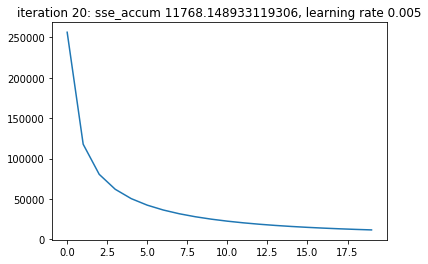

In [100]:
# Setting up a matrix of the first 1000 users with movie ratings
first_1000_users = np.matrix(user_by_movie.head(1000))

# perform funkSVD on the matrix of the top 1000 users
user_mat, movie_mat = FunkSVD(first_1000_users, 4, 0.005, 20) #fit to 1000 users with 4 latent features, lr of 0.005, and 20 iterations

`6.` Now that you have a set of predictions for each user-movie pair,  let's answer a few questions about your results. Provide the correct values for each of the variables below, and check your solutions using the tests below.

In [107]:
user_by_movie.head(1000).shape[0]*user_by_movie.head(1000).shape[1] - user_by_movie.head(1000).isnull().sum().sum()

10852

In [112]:
np.isnan(np.dot(user_mat, movie_mat)).sum()

0

In [113]:
# Replace each of the comments below with the correct values
num_ratings = user_by_movie.head(1000).shape[0]*user_by_movie.head(1000).shape[1] - user_by_movie.head(1000).isnull().sum().sum()  # How many actual ratings exist in first_1000_users
print("The number of actual ratings in the first_1000_users is {}.".format(num_ratings))
print()


ratings_for_missing = user_by_movie.head(1000).isnull().sum().sum() # How many ratings did we make for user-movie pairs that didn't actually have ratings
print("The number of ratings made for user-movie pairs that didn't have ratings is {}".format(ratings_for_missing))

The number of actual ratings in the first_1000_users is 10852.

The number of ratings made for user-movie pairs that didn't have ratings is 31234148


In [114]:
# Test your results against the solution
assert num_ratings == 10852, "Oops!  The number of actual ratings doesn't quite look right."
assert ratings_for_missing == 31234148, "Oops!  The number of movie-user pairs that you made ratings for that didn't actually have ratings doesn't look right."

# Make sure you made predictions on all the missing user-movie pairs
preds = np.dot(user_mat, movie_mat)
assert np.isnan(preds).sum() == 0
print("Nice job!  Looks like you have predictions made for all the missing user-movie pairs! But I still have one question... How good are they?")

Nice job!  Looks like you have predictions made for all the missing user-movie pairs! But I still have one question... How good are they?
